---
# UChicago COVID-19 Data Analytics

Data plays an increasingly important role in economics.

Data facilitates the measurement of key economic quantities:
* GDP
* Unemployment
* Inflation

Data is also invaluable for determining whether certain factors cause outcomes of interest:
* Do small class sizes improve student learning?
* Does police training reduce use of force?
* Does a higher minimum wage significantly increase unemployment?

We will be able to use Python to manipulate datasets, make graphs, and estimate statistical models.


---
## Putting it All Together

The following capstone exercise reviews the above.

We will use Apache Spark, Pandas, Matplotlib, and Statsmodels to assess how Covid-19 is transmitted.

Specifically, we'll examine how visits to different physical locations correlate with increases in Covid-19 cases.

Of course, this exercise is not rigorous. The results here are only exploratory. They should not be taken as indicative of a causal relationship.

In [ ]:
# Import packages
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-2.4.6-bin-hadoop2.7"
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import statsmodels.formula.api as smf
os.chdir('/C/My Drive/BigDataWorkshop')

In [ ]:
# Read in the visits data
weekly_visits = spark.read.options(
    header=True,
    inferSchema=True
    ).csv('SafeGraph_Weekly_Patterns.csv')

# Aggregate visits to the state-category level and send to Pandas
weekly_visits = weekly_visits.groupBy(['region','top_category']).agg({'raw_visit_counts':'sum'})
weekly_visits_pd = weekly_visits.toPandas()

# Stop Spark
# We are only using Spark for the initial aggregation
# Here, Spark saves us a lot of time
# In other cases, the initial aggregation may not even be possible in Pandas
spark.stop()

# Rename the Pandas columns
weekly_visits_pd.columns = ['State', 'Category', 'Visits']

# Display
weekly_visits_pd

,State,Category,Visits
0,WA,"Museums, Historical Sites, and Similar Institu...",71311.0
1,AL,Grocery Stores,194857.0
2,OR,"Museums, Historical Sites, and Similar Institu...",56538.0
3,MD,"Beer, Wine, and Liquor Stores",19432.0
4,OH,Postal Service,19264.0
...,...,...,...
7245,IL,Chemical and Allied Products Merchant Wholesalers,359.0
7246,HI,None,214.0
7247,VA,"Data Processing, Hosting, and Related Services",63.0
7248,MO,"Foundation, Structure, and Building Exterior C...",23.0


In [ ]:
# Reshape the visit data (NEW TOOL)
weekly_visits_pd_rotated = weekly_visits_pd.pivot(index='State', columns='Category', values='Visits')
weekly_visits_pd_rotated = weekly_visits_pd_rotated.reset_index()
weekly_visits_pd_rotated

In [ ]:
# Read in the Covid-19 cases data
covid_cases = pd.read_csv('covid_confirmed_usafacts.csv')

# Aggregate the cases data to the state-level
covid_cases_by_state = covid_cases.groupby('State').agg({'4/4/20':'sum','4/18/20':'sum'})

# Reset the index (to make "State" a column)
covid_cases_by_state = covid_cases_by_state.reset_index()

# Create the change in cases
covid_cases_by_state['Change'] = covid_cases_by_state['4/18/20'] - covid_cases_by_state['4/4/20']

In [ ]:
# Merge the two datasets
columns_to_keep = ['State',
                   'Restaurants and Other Eating Places',
                   'Religious Organizations',
                   'Automobile Dealers',
                   'Offices of Dentists',
                   'Child Day Care Services',
                   'Clothing Stores',
                   'Gasoline Stations',
                   'Grocery Stores',
                   'Traveler Accommodation']
OLS_data = covid_cases_by_state.merge(
    weekly_visits_pd_rotated[columns_to_keep],
    how='left',
    left_on='State',
    right_on='State')
assert len(OLS_data) == len(covid_cases_by_state)
OLS_data


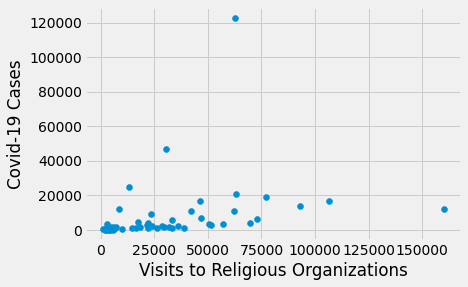

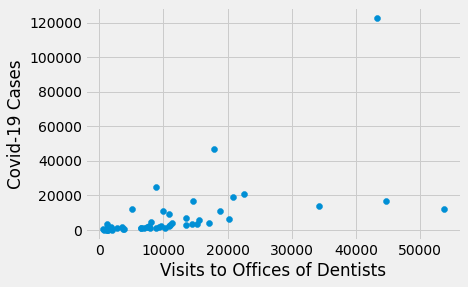

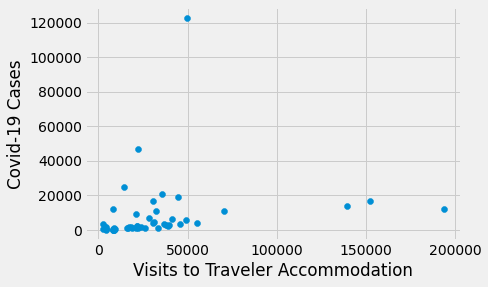

In [ ]:
# Plot some of the relationships
for column in ['Religious Organizations',
               'Offices of Dentists',
               'Traveler Accommodation']:
    plt.scatter(OLS_data[column], OLS_data['Change'])
    plt.xlabel('Visits to ' + column)
    plt.ylabel('Covid-19 Cases')
    plt.show()
    print("\n") # Printing "\n" adds a blank new line between the plots


In [ ]:
# Run a linear regression
# The Q("") is needed because the variable name has a space in it
results = smf.ols('Change ~ Q("Religious Organizations")', data=OLS_data).fit()
print(results.summary())

In [ ]:
# Run a multiple linear regression
# This is a "multiple" linear regression because the line has multiple variables
regression = 'Change ~ Q("Restaurants and Other Eating Places") + Q("Religious Organizations") + Q("Automobile Dealers") + Q("Offices of Dentists") + Q("Child Day Care Services") + Q("Clothing Stores") + Q("Gasoline Stations") + Q("Grocery Stores") + Q("Traveler Accommodation")'
results = smf.ols(regression, data=OLS_data).fit()
print(results.summary())

I want to again stress that this exercise is only exploratory.

I also want to encourage you to continue exploring this data.

In particular, what are some ways that we could improve this analysis?